# Relationship between Six Nations and World Cup Performances

In [587]:
#Install relevent programs
%pip install beautifulsoup4 requests selenium bs4
%pip install --upgrade selenium webdriver-manager

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [708]:
%pip install plotly graphviz pearsonr statsmodels

Note: you may need to restart the kernel to use updated packages.


### World Cup Top 3 Data Collection

In [591]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [593]:
def parse_html_from_url(url):
    #Fetch and parse HTML from a specified URL
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

In [595]:
def extract_data_by_section(soup, section_id):
    #Extract data from a section specified by its ID
    section = soup.find('span', {'id': section_id})
    if section:
        table = section.find_next('table', {'class': 'wikitable'})
        if table:
            return extract_table_data(table)
        else:
            print(f"No table found for {section_id}")
    else:
        print(f"No section found for {section_id}")
    return pd.DataFrame()


In [597]:
def extract_table_data(table):
    #Extract rows from the specified table
    rows = table.find_all('tr')
    data = []
    for row in rows:
        cols = row.find_all('td')
        if cols:
            year_text = cols[0].text.strip()
            try:
                year = int(year_text)  # Convert year to integer
            except ValueError:
                print(f"Skipping row, invalid year: {year_text}")
                continue
            if year > 2024:
                print(f"Skipping future tournament year: {year}")
                continue  # Skip future years
            try:
                champion = cols[2].text.strip()
                runner_up = cols[4].text.strip()
                third = cols[5].text.strip()
                data.append((year_text, champion, runner_up, third))
            except IndexError as e:
                print(f"Error processing row: {row}, error: {e}")
    return pd.DataFrame(data, columns=['Year', 'Champion', 'Runner-up', 'Third'])


In [599]:
#URL of the Wikipedia page for the Rugby World Cup
url = 'https://en.wikipedia.org/wiki/Rugby_World_Cup'
soup = parse_html_from_url(url)
section_id = 'Tournaments'
World_Cup_Data = extract_data_by_section(soup, section_id)

print("World Cup Data:")
print(World_Cup_Data)


Skipping future tournament year: 2027
Skipping future tournament year: 2031
World Cup Data:
   Year      Champion    Runner-up         Third
0  1987   New Zealand       France         Wales
1  1991     Australia      England   New Zealand
2  1995  South Africa  New Zealand        France
3  1999     Australia       France  South Africa
4  2003       England    Australia   New Zealand
5  2007  South Africa      England     Argentina
6  2011   New Zealand       France     Australia
7  2015   New Zealand    Australia  South Africa
8  2019  South Africa      England   New Zealand
9  2023  South Africa  New Zealand       England


In [601]:
World_Cup_Data.to_csv('World_Cup_Data.csv', index=False)

### World Cup Quarterfinalists Data Collection

In [603]:
import time

In [605]:
#Function to extract top teams from each pool
def extract_top_teams(pool_df):
    top_teams = []
    #Determine the number of rows per pool
    if int(url.split('/')[-1][:4]) <= 1999:
        rows_per_pool = 7
    else:
        rows_per_pool = 8
    #Iterate through each pool
    for pool_start_index in range(0, len(pool_df), rows_per_pool):
        #Get the top two teams from each pool based on points
        top_teams.extend(pool_df.iloc[pool_start_index+2:pool_start_index+4, 0].tolist())
    return top_teams


world_cup_quarterfinalists = pd.DataFrame(columns=['Year', 'Country'])

In [607]:
#Iterate through each year
for year in range(1987, 2024, 4):
    try:
        #Construct the URL (page layouts change in the year 2011)
        if year <= 2011:
            url = f'https://www.globalrugbyresults.com/{year}rugbyworldcup.html'
            table_index = 3
        else:
            url = f'https://www.globalrugbyresults.com/{year}RugbyWorldCup.html'
            table_index = 2

        time.sleep(2)

        Rugby_World_Cup_Quarters_df = pd.read_html(url)
        
        #Extract the relevant DataFrame containing pool stage results
        pool_stage_df = Rugby_World_Cup_Quarters_df[table_index]
        
        #Extract top teams from each pool
        top_teams = extract_top_teams(pool_stage_df)
        
        #Add the year to the list of years
        year_list = [year] * len(top_teams)
        
        year_df = pd.DataFrame({'Year': year_list, 'Country': top_teams})
        
        #Append the current year's data to world_cup_quarterfinalists
        world_cup_quarterfinalists = world_cup_quarterfinalists.append(year_df, ignore_index=True)
    except Exception as e:
        print(f"Error processing data for year {year}: {e}")

In [609]:
print(world_cup_quarterfinalists)

    Year       Country
0   1987     Australia
1   1987       England
2   1987         Wales
3   1987       Ireland
4   1987   New Zealand
..   ...           ...
77  2023  South Africa
78  2023         Wales
79  2023          Fiji
80  2023       England
81  2023     Argentina

[82 rows x 2 columns]


In [611]:
world_cup_quarterfinalists.to_csv('world_cup_quarterfinalists.csv', index=False)


### Six Nations Data Collection

In [613]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

In [615]:
def fetch_page(url):
    options = webdriver.ChromeOptions()
    options.add_argument('--headless') 
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    driver.get(url)
    return driver

In [617]:
def scrape_season_data(driver):
    try:
        standings = []
        #Wait for the Javascript driven dynamic content to load
        WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.CSS_SELECTOR, ".ui-table__row")))
        rows = driver.find_elements(By.CSS_SELECTOR, ".ui-table__row")
        #Debug
        #print(f"Found {len(rows)} rows")
        for row in rows:
            rank = row.find_element(By.CSS_SELECTOR, ".table__cell--rank .tableCellRank").text.strip()
            team_name = row.find_element(By.CSS_SELECTOR, ".tableCellParticipant__name").text.strip()
            total_points = row.find_element(By.CSS_SELECTOR, ".table__cell--points").text.strip()
            total_playing_points = row.find_element(By.CSS_SELECTOR, ".table__cell--totalPoints").text.strip()
            standings.append({'Rank': rank, 'Team': team_name, 'Points': total_points, 'Scored Points': total_playing_points})
            #Debug
            #print(f"Scraped data - Rank: {rank}, Team: {team_name}, Points: {total_points}")
        return standings
    except Exception as e:
        print(f"Error scraping data: {e}")
        return None


In [619]:
def compile_data(url):
    main_driver = fetch_page(url)
    #Filter only the links of interest
    links = main_driver.find_elements(By.CSS_SELECTOR, 'a[href*="/six-nations-20"]:not([href*="standings"])')
    #Debug so I dont have to go through all 24 years each time
    #year_urls = [link.get_attribute('href') for link in links if '2024' in link.text or '2023' in link.text]
    year_urls = [link.get_attribute('href') for link in links]
    
    results = []
    for year_url in year_urls:
        print(f"Processing {year_url}")
        driver_year = fetch_page(year_url)
        standings_link = driver_year.find_element(By.CSS_SELECTOR, 'a[href*="standings"]')
        standings_url = standings_link.get_attribute('href')
        
        driver_standings = fetch_page(standings_url)
        teams = scrape_season_data(driver_standings)
        if teams:
            #Extract year from the URL
            year = standings_url.split('/')[-2].split('-')[-1] if 'standings' in standings_url.split('/')[-1] else standings_url.split('/')[-3].split('-')[-1]
            for team in teams:
                results.append([year] + list(team.values()))
        driver_standings.quit()
        driver_year.quit()

    main_driver.quit()
    return pd.DataFrame(results, columns=['Year', 'Rank', 'Team', 'Points', 'Scored Points'])

In [621]:
main_url = 'https://www.livesport.com/en/rugby-union/europe/six-nations/archive/'
six_nations_data = compile_data(main_url)
print(six_nations_data)

Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2024/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2023/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2022/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2021/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2020/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2019/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2018/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2017/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2016/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2015/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2014/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2013/
Processing https://www.livesport.com/en/rugby-union/europe/six-nations-2012/

In [623]:
print(six_nations_data.columns)


Index(['Year', 'Rank', 'Team', 'Points', 'Scored Points'], dtype='object')


In [625]:
#Expand 'Scored Points' column into two new columns
six_nations_data[['Points Scored', 'Points Conceded']] = six_nations_data['Scored Points'].str.split(':', expand=True)

six_nations_data['Points Scored'] = pd.to_numeric(six_nations_data['Points Scored'])
six_nations_data['Points Conceded'] = pd.to_numeric(six_nations_data['Points Conceded'])

six_nations_data['Points Difference'] = six_nations_data['Points Scored'] - six_nations_data['Points Conceded']

#Remove 'Scored Points' column
six_nations_data = six_nations_data.drop(columns=['Scored Points'])

print(six_nations_data.head())




   Year Rank      Team Points  Points Scored  Points Conceded  \
0  2024   1.   Ireland     20            144               60   
1  2024   2.    France     15            128              122   
2  2024   3.   England     14            118              123   
3  2024   4.  Scotland     12            115              115   
4  2024   5.     Italy     11             92              126   

   Points Difference  
0                 84  
1                  6  
2                 -5  
3                  0  
4                -34  


In [627]:
six_nations_data.to_csv('Six_Nations_data.csv', index=False)

## Investment Analysis

In [629]:
import matplotlib.pyplot as plt
import seaborn as sns

In [631]:
investment_data_path = '6_nations_teams_investments.csv'
investment_data = pd.read_csv(investment_data_path)

print(investment_data)

    Year      Team  Expenditure (£/€)  Expenditure (£)
0   2023   England         99400000.0     9.940000e+07
1   2023    France        142944183.0     1.223639e+08
2   2023   Ireland         93118736.0     7.971203e+07
3   2023     Italy         37496556.9     3.209802e+07
4   2023  Scotland         75382000.0     7.538200e+07
5   2023     Wales         79500000.0     7.950000e+07
6   2022   England         77400000.0     7.740000e+07
7   2022    France        125699609.0     1.076021e+08
8   2022   Ireland        109686828.0     9.389475e+07
9   2022     Italy         36037805.5     3.084929e+07
10  2022  Scotland         61051000.0     6.105100e+07
11  2022     Wales         70100000.0     7.010000e+07
12  2021   England         57400000.0     5.740000e+07
13  2021    France         88150169.0     7.545881e+07
14  2021   Ireland         94093057.0     8.054608e+07
15  2021     Italy         32314997.0     2.766247e+07
16  2021  Scotland         48811000.0     4.881100e+07
17  2021  

In [633]:
#Cleaning data
six_nations_data['Year'] = six_nations_data['Year'].astype(str).str.strip()
investment_data['Year'] = investment_data['Year'].astype(str).str.strip()
six_nations_data['Points'] = pd.to_numeric(six_nations_data['Points'], errors='coerce')

#Filter Six Nations data for the years 2022 to 2024
six_nations_filtered = six_nations_data[six_nations_data['Year'].isin(['2024', '2023', '2022'])]

average_scores = six_nations_filtered.groupby('Team')['Points'].mean().reset_index()
average_investment = investment_data.groupby('Team')['Expenditure (£)'].mean().reset_index()

#Merge the averaged scores and investments
merged_investment_data = pd.merge(average_scores, average_investment, on='Team', how='inner')
print(merged_investment_data)

       Team     Points  Expenditure (£)
0   England  11.333333     7.806667e+07
1    France  20.000000     1.018083e+08
2   Ireland  22.666667     8.471762e+07
3     Italy   5.333333     3.020326e+07
4  Scotland  12.333333     6.174800e+07
5     Wales   5.666667     6.446667e+07


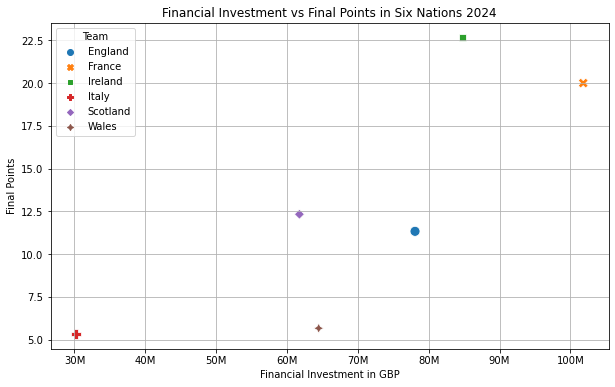

In [635]:
import matplotlib.ticker as ticker

#Plotting the relationship between Investment and Ranking
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=merged_investment_data, x='Expenditure (£)', y='Points', hue='Team', s=100, style='Team')

plt.title('Financial Investment vs Final Points in Six Nations 2024')
plt.xlabel('Financial Investment in GBP')
plt.ylabel('Final Points')
plt.grid(True)

#Format the x-axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}M'.format(x/1e6)))

plt.show()


In [637]:
print(investment_data)

    Year      Team  Expenditure (£/€)  Expenditure (£)
0   2023   England         99400000.0     9.940000e+07
1   2023    France        142944183.0     1.223639e+08
2   2023   Ireland         93118736.0     7.971203e+07
3   2023     Italy         37496556.9     3.209802e+07
4   2023  Scotland         75382000.0     7.538200e+07
5   2023     Wales         79500000.0     7.950000e+07
6   2022   England         77400000.0     7.740000e+07
7   2022    France        125699609.0     1.076021e+08
8   2022   Ireland        109686828.0     9.389475e+07
9   2022     Italy         36037805.5     3.084929e+07
10  2022  Scotland         61051000.0     6.105100e+07
11  2022     Wales         70100000.0     7.010000e+07
12  2021   England         57400000.0     5.740000e+07
13  2021    France         88150169.0     7.545881e+07
14  2021   Ireland         94093057.0     8.054608e+07
15  2021     Italy         32314997.0     2.766247e+07
16  2021  Scotland         48811000.0     4.881100e+07
17  2021  

In [639]:
print(merged_data_1)

    Year Rank      Team  Points  Expenditure (£/€)  Expenditure (£)  \
0   2023   1.   Ireland      27         93118736.0     7.971203e+07   
1   2023   2.    France      20        142944183.0     1.223639e+08   
2   2023   3.  Scotland      15         75382000.0     7.538200e+07   
3   2023   4.   England      10         99400000.0     9.940000e+07   
4   2023   5.     Wales       6         79500000.0     7.950000e+07   
5   2023   6.     Italy       1         37496556.9     3.209802e+07   
6   2022   1.    France      25        125699609.0     1.076021e+08   
7   2022   2.   Ireland      21        109686828.0     9.389475e+07   
8   2022   3.   England      10         77400000.0     7.740000e+07   
9   2022   4.  Scotland      10         61051000.0     6.105100e+07   
10  2022   5.     Wales       7         70100000.0     7.010000e+07   
11  2022   6.     Italy       4         36037805.5     3.084929e+07   
12  2021   1.     Wales      20         43800000.0     4.380000e+07   
13  20

In [640]:
#Clean data
merged_data_1['Points'] = merged_data_1['Points'].astype(int)
merged_data_1['Year'] = merged_data_1['Year'].astype(int)

#Calculate 'Expenditure per Point (£)'
merged_data_1['Expenditure per Point (£)'] = merged_data_1['Expenditure (£)'] / merged_data_1['Points']

#Handling infinite values
merged_data_1['Expenditure per Point (£)'].replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data_1['Expenditure per Point (£)'].fillna(0, inplace=True)  # Assuming you want to set 0 where calculation was not possible

print("\nFinal Data with Expenditure per Point:\n")
print(merged_data_1[['Year', 'Team', 'Points', 'Expenditure (£)', 'Expenditure per Point (£)']])


Final Data with Expenditure per Point:

    Year      Team  Points  Expenditure (£)  Expenditure per Point (£)
0   2023   Ireland      27     7.971203e+07               2.952298e+06
1   2023    France      20     1.223639e+08               6.118195e+06
2   2023  Scotland      15     7.538200e+07               5.025467e+06
3   2023   England      10     9.940000e+07               9.940000e+06
4   2023     Wales       6     7.950000e+07               1.325000e+07
5   2023     Italy       1     3.209802e+07               3.209802e+07
6   2022    France      25     1.076021e+08               4.304084e+06
7   2022   Ireland      21     9.389475e+07               4.471178e+06
8   2022   England      10     7.740000e+07               7.740000e+06
9   2022  Scotland      10     6.105100e+07               6.105100e+06
10  2022     Wales       7     7.010000e+07               1.001429e+07
11  2022     Italy       4     3.084929e+07               7.712322e+06
12  2021     Wales      20     4.380

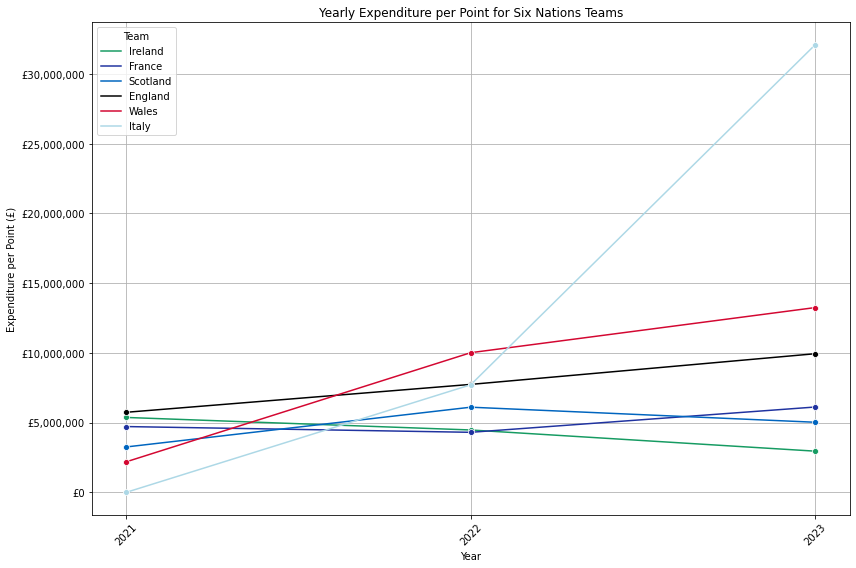

In [731]:
#Define custom palette
team_colours = {
    'Ireland': '#169b62',
    'France': '#2033a0',
    'England': '#000000',
    'Scotland': '#0065bf',
    'Italy': '#ADD8E6',
    'Wales': '#d30731'
}

plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=merged_data_1, x='Year', y='Expenditure per Point (£)', hue='Team', marker='o', palette=team_colours)

plt.title('Yearly Expenditure per Point for Six Nations Teams')
plt.xlabel('Year')
plt.ylabel('Expenditure per Point (£)')
plt.grid(True)

ax.set_xticks(merged_data_1['Year'].unique())
ax.set_xticklabels(merged_data_1['Year'].unique(), rotation=45)

#Format the y-axis to display currency
formatter = ticker.FuncFormatter(lambda x, pos: f'£{x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

plt.legend(title='Team')
plt.tight_layout()
plt.show()


In [716]:
#Correlation for investment and total points 
investment_correlation, _ = pearsonr(merged_data_1['Expenditure (£)'], merged_data_1['Points'])
print("Correlation coefficient between expenditure and points:", investment_correlation)


Correlation coefficient between expenditure and points: 0.6234089626119186


In [732]:
import plotly.graph_objects as go

#Calculate the averages for teams over time
average_data = merged_data_1.groupby('Team').agg({
    'Expenditure (£)': 'mean',
    'Points': 'mean'
}).reset_index()

average_data['Expenditure per Point (£)'] = average_data['Expenditure (£)'] / average_data['Points']

#Sort the data from highest to lowest Expenditure per Point
average_data = average_data.sort_values(by='Expenditure per Point (£)', ascending=False)

#Define team colors for consistency
team_colours_2 = {
    'Ireland': '#169b62',  
    'France': '#2033a0',  
    'England': '#FFFFFF',     
    'Scotland': '#0065bf', 
    'Italy': '#ADD8E6',    
    'Wales': '#d30731'     
}

#Define border colors
border_colors = {
    'Ireland': '#169b62',
    'France': '#2033a0',
    'England': 'red',
    'Scotland': '#0065bf',
    'Italy': '#ADD8E6',
    'Wales': 'darkgreen'
}

#Create the Plotly figure
fig = go.Figure()

#Add bars for Expenditure
fig.add_trace(go.Bar(
    x=average_data['Team'],
    y=average_data['Expenditure (£)'],
    name='Average Expenditure (£)',
    #Apply colours
    marker_color=[team_colours_2[team] for team in average_data['Team']],  
    marker_line_color=[border_colors[team] for team in average_data['Team']],  
    marker_line_width=5,
    #Add hover pop-up box with key info
    hoverinfo="text",
    hovertemplate=(
        "Team: %{x}<br>" +
        "Average Expenditure: £%{y:,.0f}<br>" +
        "Expenditure per Point: £%{customdata:.2f}<extra></extra>"  
    ),
    customdata=average_data['Expenditure per Point (£)'],
    showlegend=False
))

#Add a line for Points with secondary Y-axis
fig.add_trace(go.Scatter(
    x=average_data['Team'],
    y=average_data['Points'],
    name='Points',
    mode='lines+markers',
    line=dict(color='gold', width=3),
    yaxis='y2'
))

#layout of both y-axis
fig.update_layout(
    title='Financial Investment vs Final Points in Six Nations 2022-2024',
    xaxis_title='Countries',
    yaxis=dict(
        title='Average Investment (£)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
        tickprefix="£",
        ticksuffix="M",
        position=0 
    ),
    yaxis2=dict(
        title='Average Points',
        titlefont=dict(color='gold'),
        tickfont=dict(color='gold'),
        overlaying='y',
        side='right',
        position=1
    ),
    plot_bgcolor='white',
    legend=dict(x=0.70, y=0.99, bordercolor='black', borderwidth=1)
)

#Remove grid lines for clarity
fig.update_xaxes(showgrid=False, linewidth=1, linecolor='black')
fig.update_yaxes(showgrid=False, linewidth=1, linecolor='black')


#Add a subnote 
fig.add_annotation(
    x=0.5,
    y=-0.2,
    xref="paper",
    yref="paper",
    text="Data ordered from highest to lowest Expenditure per Point",
    showarrow=False,
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    align="center"
)


fig.show()


### World Cup Quarter Finalists (Top 8) Analysis

In [644]:
#Filter the data to include only Six Nations teams
six_nations_teams = ['England', 'Scotland', 'Wales', 'Ireland', 'France', 'Italy']  # Assuming Italy is included in the Six Nations
six_nations_data_teams = world_cup_quarterfinalists[world_cup_quarterfinalists['Country'].isin(six_nations_teams)]

#Pivot the dataFrame to get the count of appearances for each team in each year
heatmap_data_quarters = six_nations_data_teams.pivot_table(index='Country', columns='Year', aggfunc='size', fill_value=0)

#Not all Six Nations teams will have made the quarter finals ever, so append them in for consistency
for team in six_nations_teams:
    if team not in heatmap_data_quarters.index:
        heatmap_data_quarters.loc[team] = [0] * len(heatmap_data_quarters.columns)

print(heatmap_data_quarters)        
        



Year      1987  1991  1995  1999  2003  2007  2011  2015  2019  2023
Country                                                             
England      1     1     1     1     1     1     1     0     1     1
France       1     1     1     1     1     1     1     1     1     1
Ireland      1     1     1     1     1     0     1     1     1     1
Scotland     1     1     1     1     1     1     0     1     0     0
Wales        1     0     0     1     1     0     1     1     1     1
Italy        0     0     0     0     0     0     0     0     0     0


#### Visualisation of Quarterfinals Apperences of Six Nations Teams

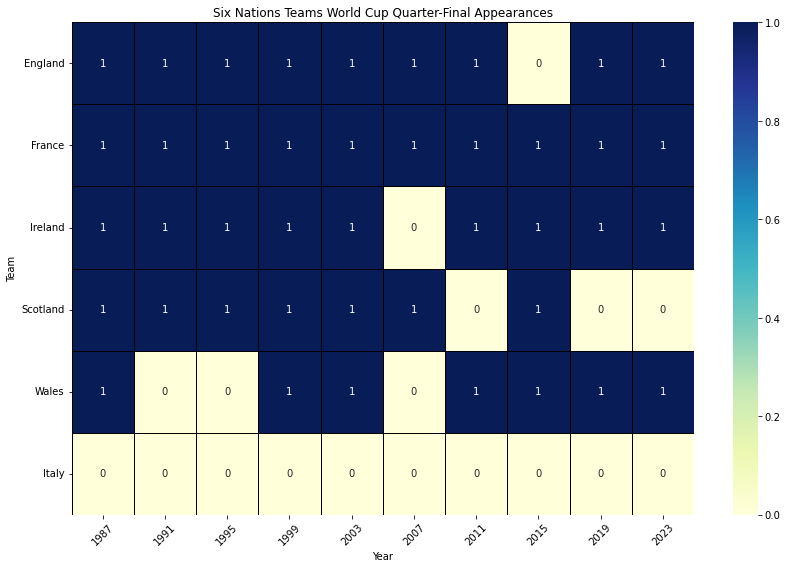

In [645]:
#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_quarters, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5, linecolor='black')
plt.title('Six Nations Teams World Cup Quarter-Final Appearances')
plt.xlabel('Year')
plt.ylabel('Team')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [646]:
#Reshape the dataFrame
long_format = pd.melt(world_cup_data, id_vars='Year', value_vars=['Champion', 'Runner-up', 'Third'], var_name='Placement', value_name='Country')
filtered_data = long_format[long_format['Country'].isin(six_nations_teams)]

#Pivot table
heatmap_data_top3 = filtered_data.pivot_table(index='Country', columns='Year', aggfunc='size', fill_value=0)

#Same as above not all teams from the Six Nations will have reached a Top 3 position in the World Cup
for team in six_nations_teams:
    if team not in heatmap_data_top3.index:
        heatmap_data_top3.loc[team] = [0] * len(heatmap_data_top3.columns)  # Add a row of zeros

#Ensure the team order in the heatmap matches quarter finalists
heatmap_data = heatmap_data_top3.loc[six_nations_teams]


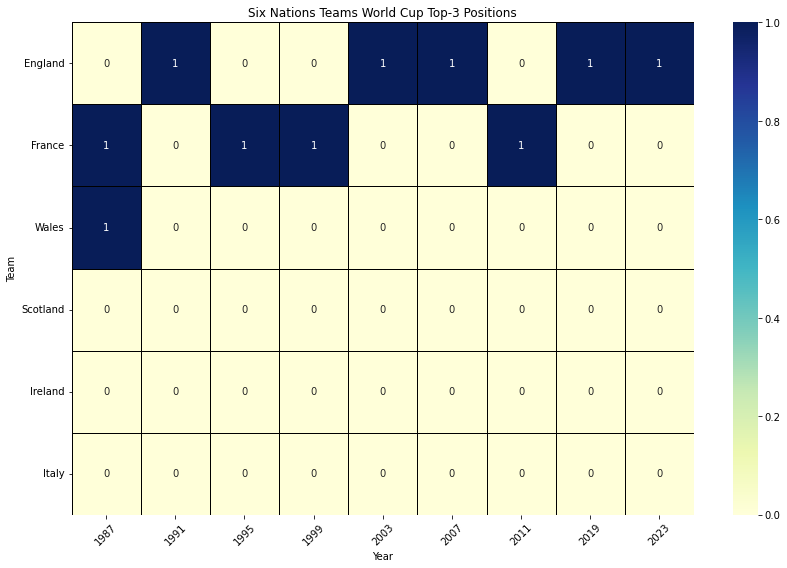

In [647]:
#Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_top3, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5, linecolor='black')
plt.title('Six Nations Teams World Cup Top-3 Positions')
plt.xlabel('Year')
plt.ylabel('Team')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

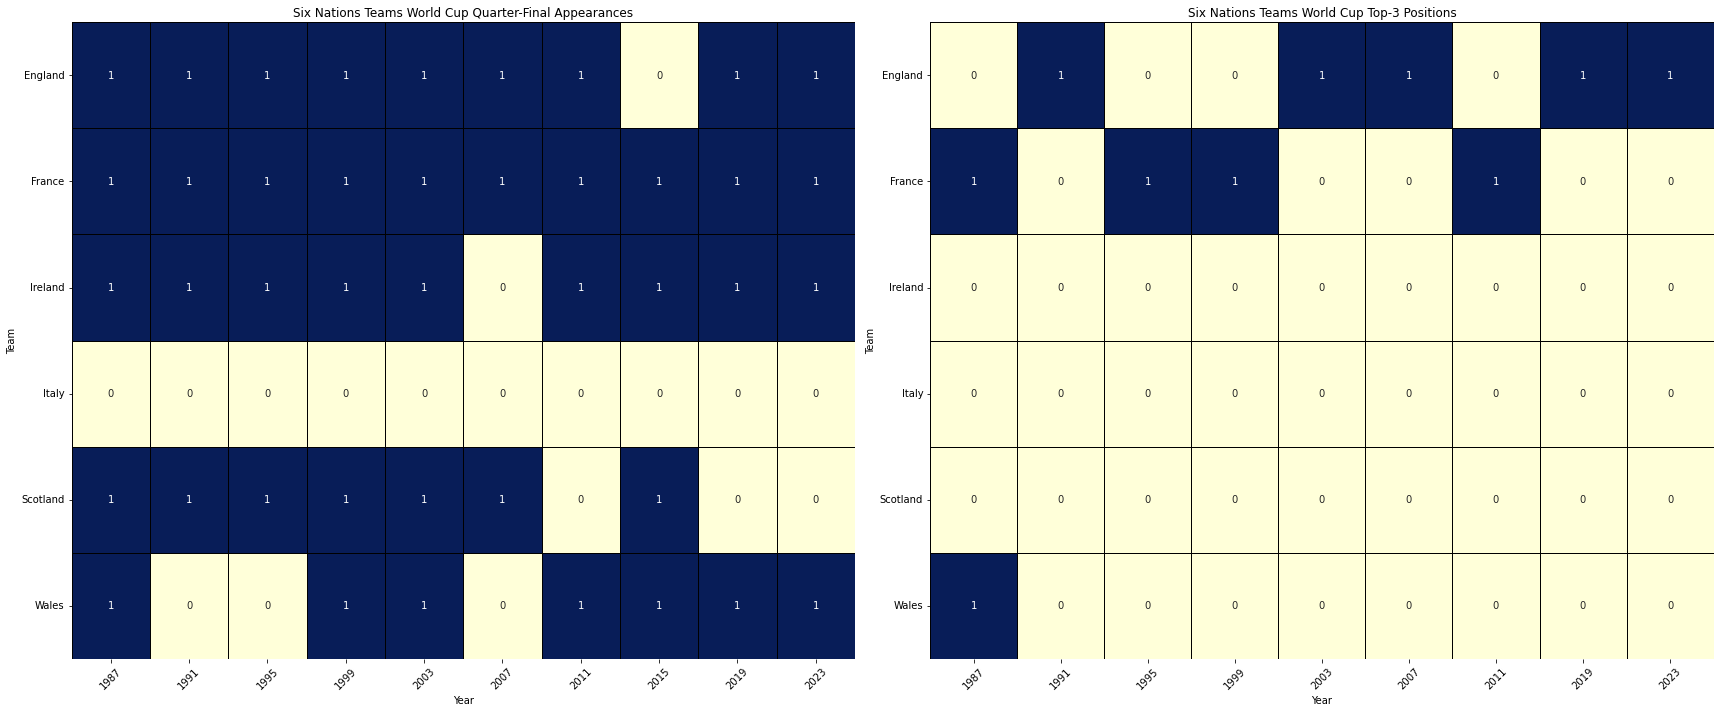

Year      1987  1991  1995  1999  2003  2007  2011  2019  2023
Country                                                       
England      0     1     0     0     1     1     0     1     1
France       1     0     1     1     0     0     1     0     0
Ireland      0     0     0     0     0     0     0     0     0
Italy        0     0     0     0     0     0     0     0     0
Scotland     0     0     0     0     0     0     0     0     0
Wales        1     0     0     0     0     0     0     0     0


In [648]:
#Sort the indices of the DataFrame
heatmap_data_quarters = heatmap_data_quarters.sort_index()
heatmap_data_top3 = heatmap_data_top3.sort_index()

#Combine plots into one frame
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))  # Adjust figsize as needed

#World Cup Quarter-Final Appearances
sns.heatmap(heatmap_data_quarters, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5, linecolor='black', ax=axes[0], cbar=False)
axes[0].set_title('Six Nations Teams World Cup Quarter-Final Appearances')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Team')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

#World Cup Top-3 Appearances
sns.heatmap(heatmap_data_top3, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5, linecolor='black', ax=axes[1], cbar=False)
axes[1].set_title('Six Nations Teams World Cup Top-3 Positions')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Team')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print (heatmap_data_top3)

#### Correlation between Six Nations performance and reaching World Cup Quarterfinals 

In [649]:
#Reshape and Clean Data
heatmap_data_long = heatmap_data_quarters.reset_index().melt(id_vars='Country', var_name='Year', value_name='QuarterFinalist')
heatmap_data_long['Year'] = heatmap_data_long['Year'].astype(int)

#Rename columns for clarity and consistency
heatmap_data_long.rename(columns={'Country': 'Team'}, inplace=True)

#Clean six_nations_data
six_nations_data['Year'] = six_nations_data['Year'].astype(int)
six_nations_data['Points'] = pd.to_numeric(six_nations_data['Points'])
six_nations_data['Points Scored'] = pd.to_numeric(six_nations_data['Points Scored'])
six_nations_data['Points Conceded'] = pd.to_numeric(six_nations_data['Points Conceded'])

merged_data = pd.merge(six_nations_data, heatmap_data_long, on=['Year', 'Team'])

#Calculate the correlations
correlation_points = merged_data['Points'].corr(merged_data['QuarterFinalist'])
correlation_points_scored = merged_data['Points Scored'].corr(merged_data['QuarterFinalist'])
correlation_points_conceded = merged_data['Points Conceded'].corr(merged_data['QuarterFinalist'])

print(f"The correlation between Six Nations total points and reaching the World Cup quarter-finals is: {correlation_points:.3f}")
print(f"The correlation between Six Nations points scored and reaching the World Cup quarter-finals is: {correlation_points_scored:.3f}")
print(f"The correlation between Six Nations points conceded and reaching the World Cup quarter-finals is: {correlation_points_conceded:.3f}")

The correlation between Six Nations total points and reaching the World Cup quarter-finals is: 0.334
The correlation between Six Nations points scored and reaching the World Cup quarter-finals is: 0.291
The correlation between Six Nations points conceded and reaching the World Cup quarter-finals is: -0.427


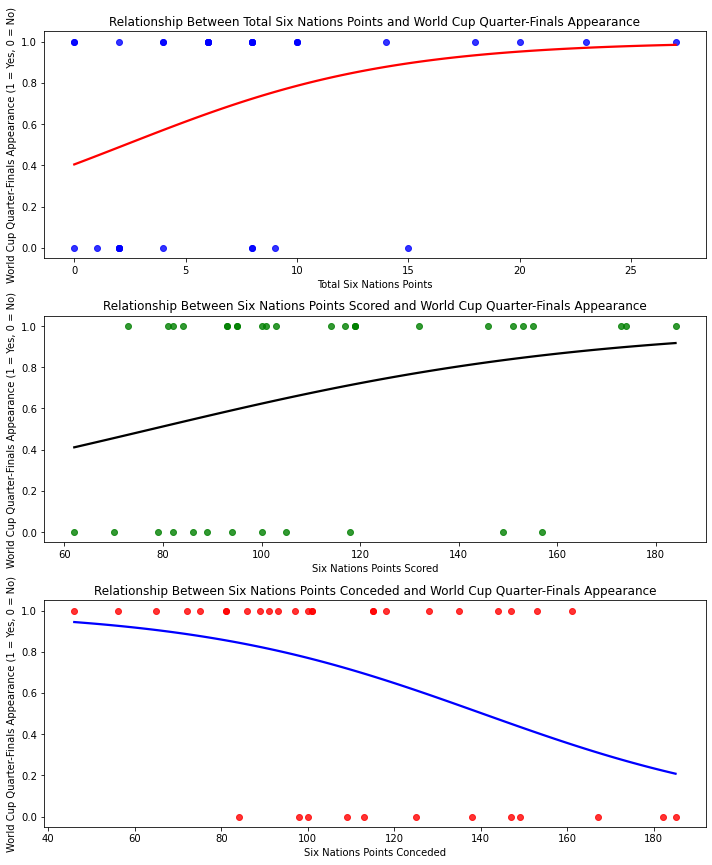

In [650]:
plt.figure(figsize=(10, 12))

#Subplot 1: Total Points
plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
sns.regplot(x='Points', y='QuarterFinalist', data=merged_data, logistic=True, ci=None, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Relationship Between Total Six Nations Points and World Cup Quarter-Finals Appearance')
plt.xlabel('Total Six Nations Points')
plt.ylabel('World Cup Quarter-Finals Appearance (1 = Yes, 0 = No)')

#Subplot 2: Points Scored
plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
sns.regplot(x='Points Scored', y='QuarterFinalist', data=merged_data, logistic=True, ci=None, scatter_kws={'color': 'green'}, line_kws={'color': 'black'})
plt.title('Relationship Between Six Nations Points Scored and World Cup Quarter-Finals Appearance')
plt.xlabel('Six Nations Points Scored')
plt.ylabel('World Cup Quarter-Finals Appearance (1 = Yes, 0 = No)')

#Subplot 3: Points Conceded
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
sns.regplot(x='Points Conceded', y='QuarterFinalist', data=merged_data, logistic=True, ci=None, scatter_kws={'color': 'red'}, line_kws={'color': 'blue'})
plt.title('Relationship Between Six Nations Points Conceded and World Cup Quarter-Finals Appearance')
plt.xlabel('Six Nations Points Conceded')
plt.ylabel('World Cup Quarter-Finals Appearance (1 = Yes, 0 = No)')

plt.tight_layout()
plt.show()


In [651]:
import statsmodels.api as sm

#Add a constant to the independent variable
merged_data['intercept'] = 1.0

#Total Points Model
logit_model_points = sm.Logit(merged_data['QuarterFinalist'], merged_data[['intercept', 'Points']])
result_points = logit_model_points.fit()
print("Model Summary for Total Points:")
print(result_points.summary())

#Points Scored Model
logit_model_points_scored = sm.Logit(merged_data['QuarterFinalist'], merged_data[['intercept', 'Points Scored']])
result_points_scored = logit_model_points_scored.fit()
print("\nModel Summary for Points Scored:")
print(result_points_scored.summary())

#Points Conceded Model
logit_model_points_conceded = sm.Logit(merged_data['QuarterFinalist'], merged_data[['intercept', 'Points Conceded']])
result_points_conceded = logit_model_points_conceded.fit()
print("\nModel Summary for Points Conceded:")
print(result_points_conceded.summary())


Optimization terminated successfully.
         Current function value: 0.566361
         Iterations 6
Model Summary for Total Points:
                           Logit Regression Results                           
Dep. Variable:        QuarterFinalist   No. Observations:                   36
Model:                          Logit   Df Residuals:                       34
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 May 2024   Pseudo R-squ.:                  0.1102
Time:                        15:26:56   Log-Likelihood:                -20.389
converged:                       True   LL-Null:                       -22.915
Covariance Type:            nonrobust   LLR p-value:                   0.02461
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3878      0.626     -0.619      0.536      -1.615       0.8

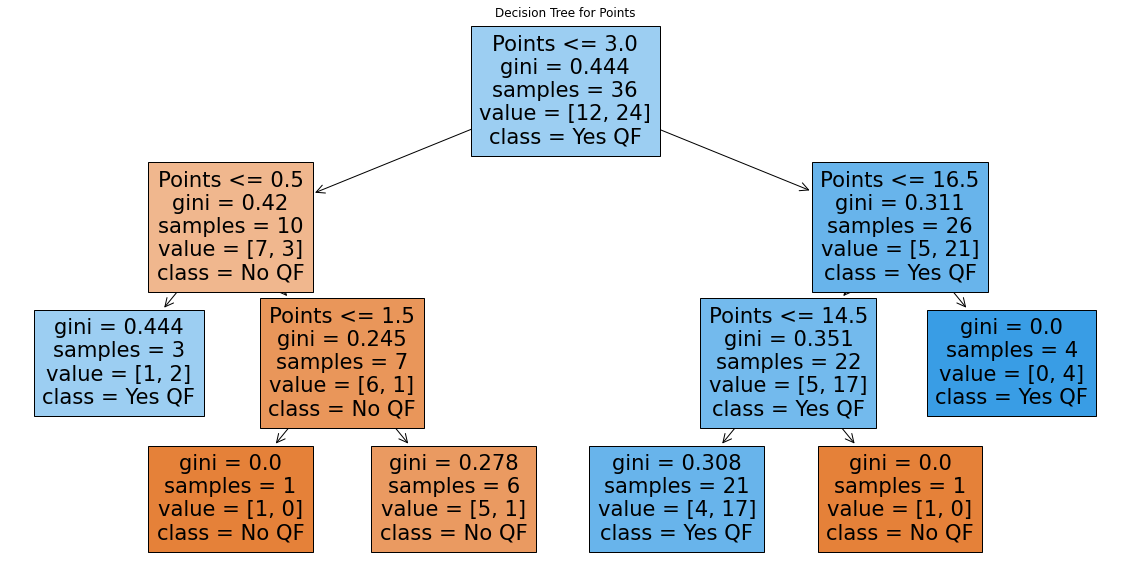

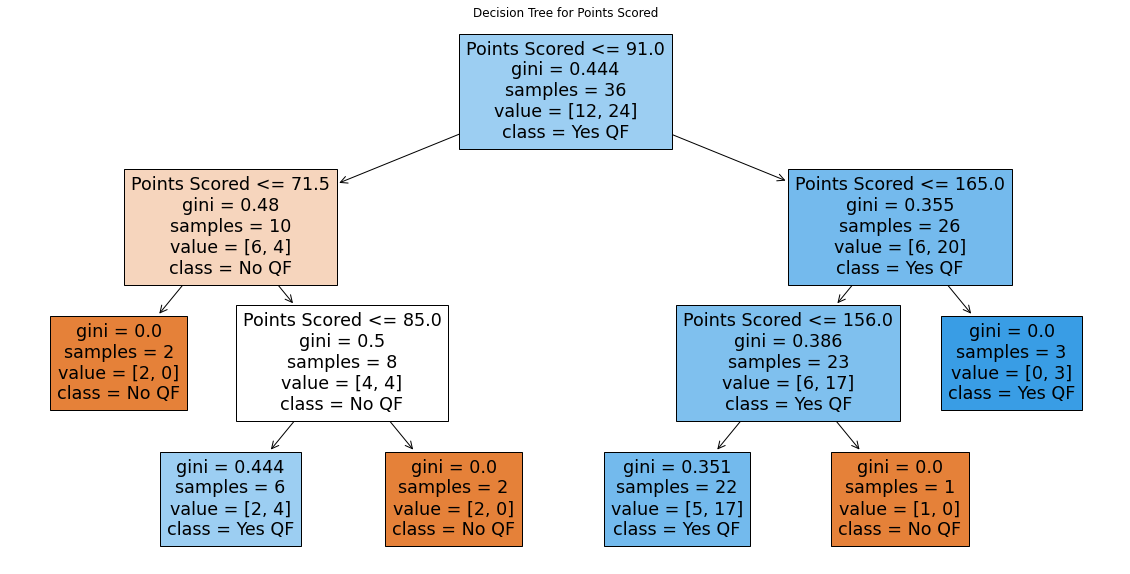

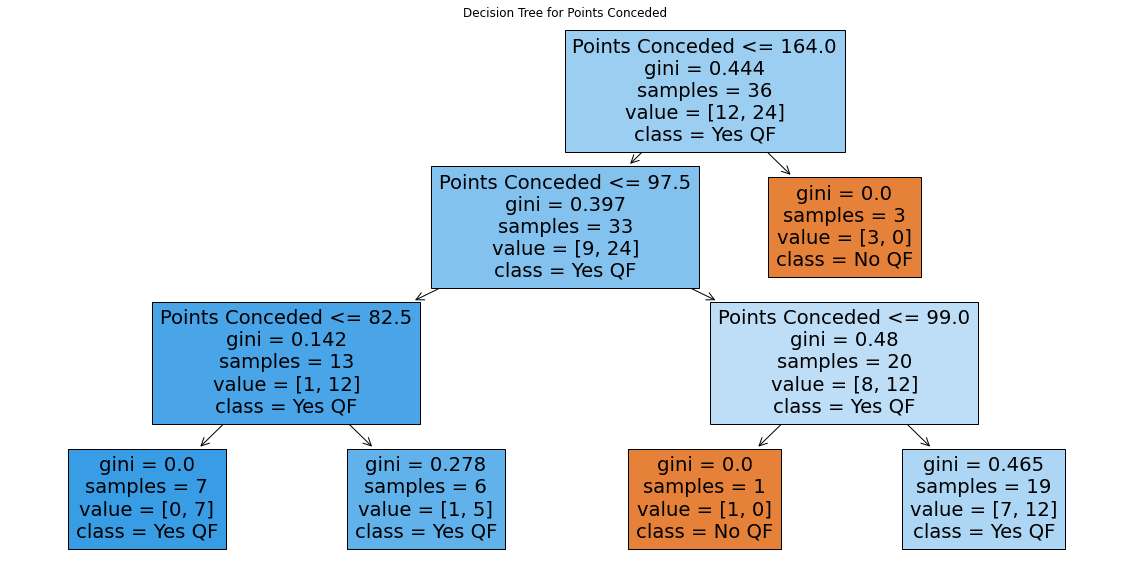

In [652]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

features = ['Points', 'Points Scored', 'Points Conceded']
feature_names = [['Points'], ['Points Scored'], ['Points Conceded']]
class_names = ['No QF', 'Yes QF']

#Iterate through each feature and build a separate model
for feature, name in zip(features, feature_names):
    tree_model = DecisionTreeClassifier(max_depth=3)
    tree_model.fit(merged_data[name], merged_data['QuarterFinalist'])

    #Plot the decision tree
    plt.figure(figsize=(20,10))
    plot_tree(tree_model, filled=True, feature_names=name, class_names=class_names)
    plt.title(f"Decision Tree for {name[0]}")
    plt.show()


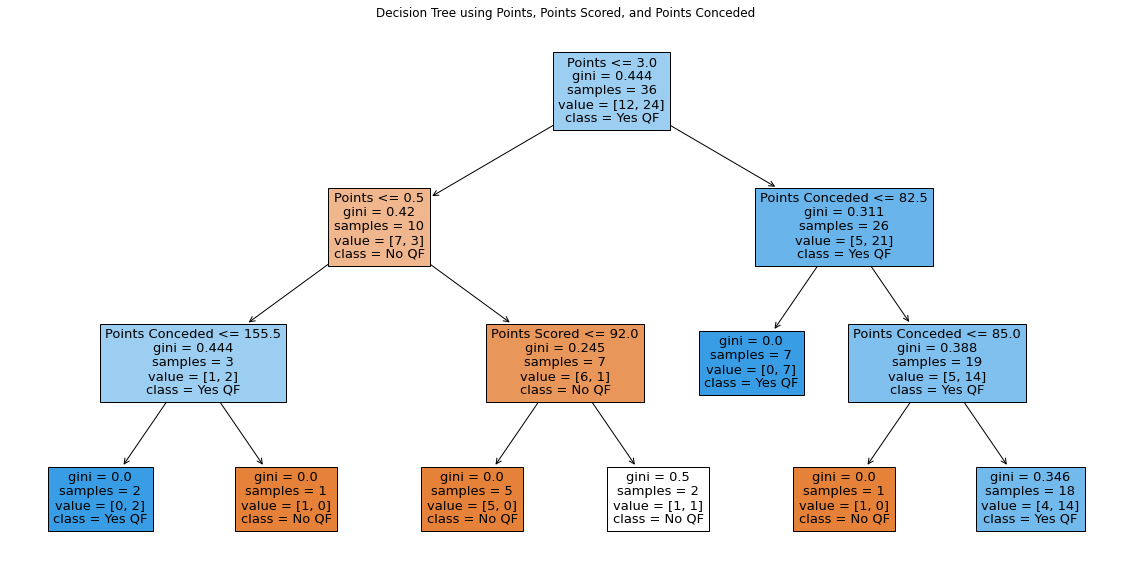

In [653]:
#Create and fit the model using all features
combined_tree_model = DecisionTreeClassifier(max_depth=3)
combined_tree_model.fit(merged_data[features], merged_data['QuarterFinalist'])

#Plot the decision tree for the combined model
plt.figure(figsize=(20,10))
plot_tree(combined_tree_model, filled=True, feature_names=features, class_names=class_names)
plt.title("Decision Tree using Points, Points Scored, and Points Conceded")
plt.show()


##### Average performances in Six Nations to reach World Cup Quarterfinals and Top 3

In [684]:
#Average Total Points
#Reshape world_cup_data to have a single 'Country' column for teams in top 3
top3_teams = world_cup_data.melt(id_vars='Year', value_vars=['Champion', 'Runner-up', 'Third'], var_name='Position', value_name='Team')

#Clean data
six_nations_data['Team'] = six_nations_data['Team'].str.strip()
top3_teams['Team'] = top3_teams['Team'].str.strip()
world_cup_quarterfinalists['Country'] = world_cup_quarterfinalists['Country'].str.strip()


#Make merged dataframes
top3_merge = pd.merge(six_nations_data, top3_teams, on=['Year', 'Team'])
quarterfinals_merge = pd.merge(six_nations_data, world_cup_quarterfinalists, left_on=['Year', 'Team'], right_on=['Year', 'Country'])

#Calculate averages
average_points_top3 = top3_merge['Points'].mean()
average_points_quarterfinals = quarterfinals_merge['Points'].mean()
print(f"Average Six Nations points for top 3 positions in the World Cup: {average_points_top3}")
print(f"Average Six Nations points for World Cup quarterfinals qualification: {average_points_quarterfinals}")


Average Six Nations points for top 3 positions in the World Cup: 10.0
Average Six Nations points for World Cup quarterfinals qualification: 9.083333333333334


In [688]:
#Average Points Scored
#Calculate averages
average_points_scored_top3 = top3_merge['Points Scored'].mean()
average_points_scored_quarterfinals = quarterfinals_merge['Points Scored'].mean()

print(f"Average Six Nations points for top 3 positions in the World Cup: {average_points_scored_top3}")
print(f"Average Six Nations points for World Cup quarterfinals qualification: {average_points_scored_quarterfinals}")


Average Six Nations points for top 3 positions in the World Cup: 138.6
Average Six Nations points for World Cup quarterfinals qualification: 119.0


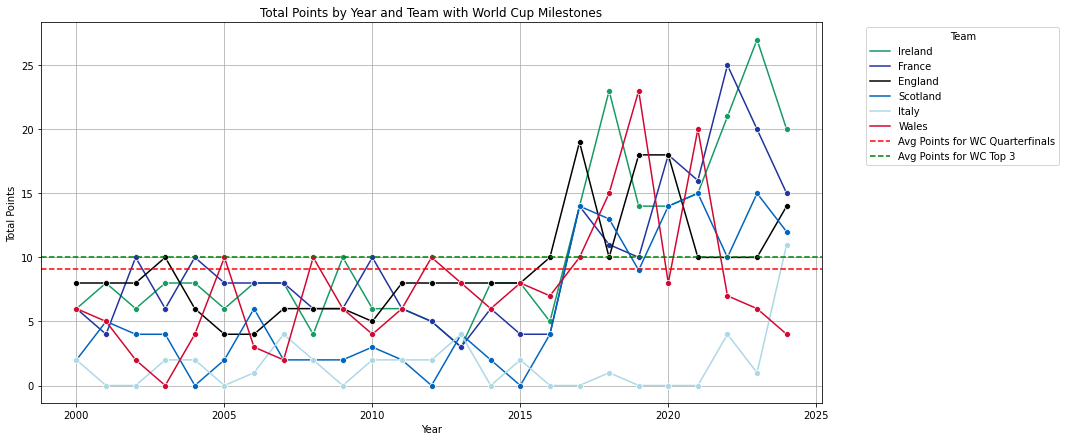

In [733]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Year', y='Points', data=six_nations_data, hue='Team', palette=team_colours, marker='o')
plt.axhline(y=average_points_quarterfinals, color='r', linestyle='--', label='Avg Points for WC Quarterfinals')
plt.axhline(y=average_points_top3, color='g', linestyle='--', label='Avg Points for WC Top 3')
plt.title('Total Points by Year and Team with World Cup Milestones')
plt.xlabel('Year')
plt.ylabel('Total Points')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


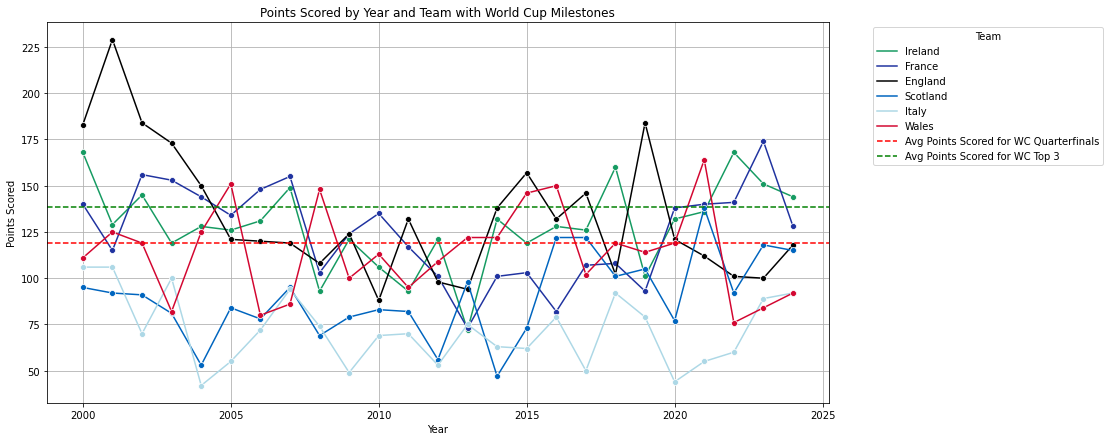

In [734]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Year', y='Points Scored', data=six_nations_data, hue='Team', palette=team_colours, marker='o')
plt.axhline(y=average_points_scored_quarterfinals, color='r', linestyle='--', label='Avg Points Scored for WC Quarterfinals')
plt.axhline(y=average_points_scored_top3, color='g', linestyle='--', label='Avg Points Scored for WC Top 3')
plt.title('Points Scored by Year and Team with World Cup Milestones')
plt.xlabel('Year')
plt.ylabel('Points Scored')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [739]:
#Splitting the data due to Total Points scoring system change
pre_2017_data = six_nations_data[six_nations_data['Year'] < 2017]
post_2017_data = six_nations_data[six_nations_data['Year'] >= 2017]

#Merging with World Cup data
pre_2017_top3_merge = pd.merge(pre_2017_data, top3_teams, on=['Year', 'Team'])
pre_2017_quarterfinals_merge = pd.merge(pre_2017_data, world_cup_quarterfinalists, left_on=['Year', 'Team'], right_on=['Year', 'Country'])

post_2017_top3_merge = pd.merge(post_2017_data, top3_teams, on=['Year', 'Team'])
post_2017_quarterfinals_merge = pd.merge(post_2017_data, world_cup_quarterfinalists, left_on=['Year', 'Team'], right_on=['Year', 'Country'])

#Calculating averages
#Pre 2017
average_points_top3_pre_2017 = pre_2017_top3_merge['Points'].mean()
average_points_quarterfinals_pre_2017 = pre_2017_quarterfinals_merge['Points'].mean()

#Post 2017
average_points_top3_post_2017 = post_2017_top3_merge['Points'].mean()
average_points_quarterfinals_post_2017 = post_2017_quarterfinals_merge['Points'].mean()


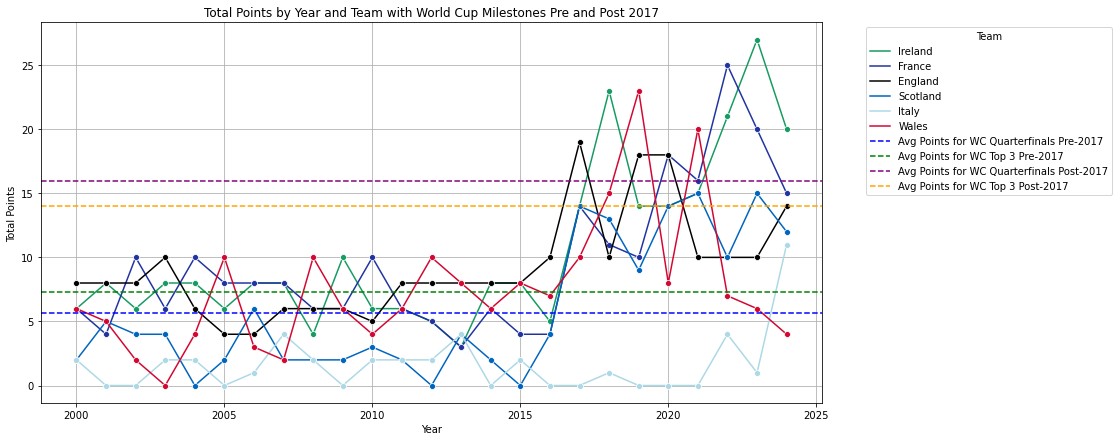

In [738]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Year', y='Points', data=six_nations_data, hue='Team', palette=team_colors, marker='o')
plt.axhline(y=average_points_quarterfinals_pre_2017, color='blue', linestyle='--', label='Avg Points for WC Quarterfinals Pre-2017')
plt.axhline(y=average_points_top3_pre_2017, color='green', linestyle='--', label='Avg Points for WC Top 3 Pre-2017')
plt.axhline(y=average_points_quarterfinals_post_2017, color='purple', linestyle='--', label='Avg Points for WC Quarterfinals Post-2017')
plt.axhline(y=average_points_top3_post_2017, color='orange', linestyle='--', label='Avg Points for WC Top 3 Post-2017')
plt.title('Total Points by Year and Team with World Cup Milestones Pre and Post 2017')
plt.xlabel('Year')
plt.ylabel('Total Points')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


#### Correlation between Six Nations Winner and reaching World Cup Top 3

In [689]:
#Find the winners from each six nations
six_nations_data['Rank'] = six_nations_data['Rank'].str.strip()  # Clean any whitespace
six_nations_winners = six_nations_data[six_nations_data['Rank'] == '1.']
print(six_nations_winners)

     Year Rank     Team  Points  Points Scored  Points Conceded  \
0    2024   1.  Ireland      20            144               60   
6    2023   1.  Ireland      27            151               72   
12   2022   1.   France      25            141               73   
18   2021   1.    Wales      20            164              103   
24   2020   1.  England      18            121               77   
30   2019   1.    Wales      23            114               65   
36   2018   1.  Ireland      23            160               82   
42   2017   1.  England      19            146               81   
48   2016   1.  England      10            132               70   
54   2015   1.  Ireland       8            119               56   
60   2014   1.  Ireland       8            132               49   
66   2013   1.    Wales       8            122               66   
72   2012   1.    Wales      10            109               58   
78   2011   1.  England       8            132               8

In [692]:
#Merge Six Nations winners with World Cup top 3 data
winners_top3_merge = pd.merge(six_nations_winners, top3_teams, left_on=['Year', 'Team'], right_on=['Year', 'Team'])

#Create a binary column indicating if the Six Nations winner was in the top 3 of the World Cup
winners_top3_merge['Top_3_Finish'] = 1 

print(winners_top3_merge)

   Year Rank     Team  Points  Points Scored  Points Conceded  \
0  2003   1.  England      10            173               46   

   Points Difference  Top_3_Finish  Position  
0                127             1  Champion  


In [715]:
#Correlation Calculations
#Ensure 'six_nations_winners' is independent
six_nations_winners = six_nations_data[six_nations_data['Rank'].str.strip() == '1.'].copy()

#To remove the copy of a slice error
six_nations_winners.loc[:, 'Top_3_Finish'] = six_nations_winners.apply(
    lambda row: 1 if (row['Year'], row['Team']) in list(zip(winners_top3_merge['Year'], winners_top3_merge['Team'])) else 0, 
    axis=1
)

#Correlation calc
from scipy.stats import pearsonr
correlation, p_value = pearsonr(six_nations_winners['Points'], six_nations_winners['Top_3_Finish'])
print("Correlation coefficient:", correlation)
print("P-value:", p_value)


Correlation coefficient: -0.10305766184139871
P-value: 0.6239809121574545


In [710]:
import statsmodels.api as sm

six_nations_winners['Non_Top_3_Finish'] = six_nations_winners['Top_3_Finish'].apply(lambda x: 1 if x == 0 else 0)

#Add an intercept term
six_nations_winners['intercept'] = 1

#Logistic regression model
logit_model = sm.Logit(six_nations_winners['Non_Top_3_Finish'], six_nations_winners[['intercept', 'Points']])

result = logit_model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.161135
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:       Non_Top_3_Finish   No. Observations:                   25
Model:                          Logit   Df Residuals:                       23
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 May 2024   Pseudo R-squ.:                 0.04054
Time:                        21:15:59   Log-Likelihood:                -4.0284
converged:                       True   LL-Null:                       -4.1986
Covariance Type:            nonrobust   LLR p-value:                    0.5596
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6967      2.986      0.568      0.570      -4.155       7.548
Points         0.1305      0.